# EE502 Project
## Use DREAMER dataset to create a ML model that will classify ECG data in a range of emotions responses
## Ernesto Sola-Thomas 
## Fall 2023 - Clarkson University

In [1]:
# Nvidia RAPIDS (GPU accelerated training)
import cuml
import cudf

from cuml.model_selection import train_test_split
from cuml.ensemble import RandomForestClassifier
from cuml.svm import SVC
from cuml.svm import LinearSVC
from cuml.linear_model import LogisticRegression
from cuml.decomposition import PCA


# ECG Raw data processing tool
import heartpy as hp

# Pickle to read and write files with dataset 
import pickle

# Standard Libraries
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import itertools
import copy

In [2]:
import warnings

# Filter out specific RuntimeWarning from numpy
warnings.filterwarnings('ignore', category=RuntimeWarning, module='numpy')

# Filter out specific UserWarning from scipy
warnings.filterwarnings('ignore', category=UserWarning, module='scipy')

# Define Functions

In [3]:
# Global Parameters
num_of_participants = 23
num_of_clips = 18

#In Hz:
cutoff = [0.5, 45]
sample_rate = 256.0
order = 3
filtertype ='bandpass'

# Features
window_size = 20480

In [4]:
# Global Functions

"""
data_filter takes in the RAW ECG data and will filter out noice and remove DC offset, see parameters defined above to finetune filter.

Input:  pandas dataframe with RAW ECG data 
Output: pandas dataframe with filtered/denoised data
"""
def data_filter (data_in):
    data = dict(data_in)
    # Separate data by channel
    for participant in data.keys():
        #print("Starting " + participant)
        for clip_num in range(0, num_of_clips):
            # Filter both channels from baseline
            CH1 = [row[0] for row in data[participant]['ECG']['baseline'][clip_num]]
            CH1_filtered = hp.filter_signal(CH1, cutoff = cutoff, sample_rate = sample_rate, order = order, filtertype=filtertype)
            # CH1_filtered = hp.butter_lowpass_filter(data, cutoff=cutoff, sample_rate=sample_rate, order=order)

            CH2 = [row[1] for row in data[participant]['ECG']['baseline'][clip_num]]
            CH2_filtered = hp.filter_signal(CH2, cutoff = cutoff, sample_rate = sample_rate, order = order, filtertype=filtertype)
            # CH2_filtered = hp.butter_lowpass_filter(data, cutoff=cutoff, sample_rate=sample_rate, order=order)

            s_clip = "clip " + str(clip_num+1) 

            data[participant]['ECG'][s_clip] = {}
            data[participant]['ECG'][s_clip]['CH1'] = {}
            data[participant]['ECG'][s_clip]['CH1']['baseline'] = CH1_filtered.tolist()
            data[participant]['ECG'][s_clip]['CH2'] = {}
            data[participant]['ECG'][s_clip]['CH2']['baseline'] = CH2_filtered.tolist()

            
            # Filter both channels from stimuli
            CH1 = [row[0] for row in data[participant]['ECG']['stimuli'][clip_num]]
            CH1_filtered = hp.filter_signal(CH1, cutoff = cutoff, sample_rate = sample_rate, order = order, filtertype=filtertype)
            # CH1_filtered = hp.butter_lowpass_filter(data, cutoff=cutoff, sample_rate=sample_rate, order=order)

            CH2 = [row[1] for row in data[participant]['ECG']['stimuli'][clip_num]]
            CH2_filtered = hp.filter_signal(CH2, cutoff = cutoff, sample_rate = sample_rate, order = order, filtertype=filtertype)
            # CH2_filtered = hp.butter_lowpass_filter(data, cutoff=cutoff, sample_rate=sample_rate, order=order)

            data[participant]['ECG'][s_clip]['CH1']['stimuli'] = CH1_filtered.tolist()
            data[participant]['ECG'][s_clip]['CH2']['stimuli'] = CH2_filtered.tolist()

            data[participant]['ECG'][s_clip]['ScoreValence'] = data[participant]['ScoreValence'][clip_num]
            data[participant]['ECG'][s_clip]['ScoreArousal'] = data[participant]['ScoreArousal'][clip_num]
            data[participant]['ECG'][s_clip]['ScoreDominance'] = data[participant]['ScoreDominance'][clip_num]
            
            print("Done filtering raw for " + participant + " at clip#" + str(clip_num+1) + "                 ", end="\r", flush=True)
        data[participant]['ECG'].pop('stimuli')
        data[participant]['ECG'].pop('baseline')

        data[participant].pop('ScoreValence')
        data[participant].pop('ScoreArousal')
        data[participant].pop('ScoreDominance')
    
    print("All done.... Highpass filter applied, cutoff: [" + str(cutoff[0]) + "," + str(cutoff[1]) + "]Hz")
    return data

"""
extract_ecg_features takes in the denoised ECG data and will extract features to be used to train the ML model.
The extracted features include: 
"""
def extract_ecg_features(processed_data):
    combined_data = pd.DataFrame()
    sample_rate = 256  # Assuming 256 is the sample rate

    for CH in ['CH1', 'CH2']:
        for participant in processed_data:
            for clip in processed_data[participant]['ECG']:
                print("Processing " + participant + " " + clip + " " + CH + "          ", end="\r", flush=True)
                stimuli_data = processed_data[participant]['ECG'][clip][CH]['stimuli']

                # Iterate over the data in windows of size window_size
                for start in range(0, len(stimuli_data), window_size):
                    end = start + window_size
                    window_data = stimuli_data[start:end]

                    # Check if the window has enough data, if not, skip this window
                    if len(window_data) < window_size:
                        continue

                    # Process the windowed data
                    hp_tupple = hp.process(window_data, sample_rate)
                    features_df = pd.DataFrame([hp_tupple[1]])
                    features_df['ScoreValence'] = processed_data[participant]['ECG'][clip]['ScoreValence']
                    features_df['ScoreArousal'] = processed_data[participant]['ECG'][clip]['ScoreArousal']
                    features_df['ScoreDominance'] = processed_data[participant]['ECG'][clip]['ScoreDominance']

                    # Append the features to the combined data
                    combined_data = pd.concat([combined_data, features_df], ignore_index=True)

    print("\nDone extracting time domain features")
    return combined_data

"""
Plot Findings
"""
def plot_model_results(data, title):
    # Preparing data for grouped bar chart
    labels = list(set(param for params in data.values() for param in params.keys()))
    labels.sort()
    num_labels = len(labels)

    # Number of models
    num_models = len(data)

    # Creating an array for each model's scores
    scores = {model: [data[model].get(label, 0) for label in labels] for model in data.keys()}

    # Setting up the bar chart
    fig, ax = plt.subplots(figsize=(12, 8))
    bar_width = 0.25
    index = np.arange(num_labels)

    # Creating bars for each model
    for i, (model, model_scores) in enumerate(scores.items()):
        ax.bar(index + i * bar_width, model_scores, bar_width, label=model)

    # Finalizing the plot
    ax.set_xlabel('Parameter Combinations')
    ax.set_ylabel('Scores')
    ax.set_title(title)
    ax.set_xticks(index + bar_width)
    ax.set_xticklabels(labels, rotation=90)
    ax.legend()

    plt.show()


"""
Plot findings of PCA models
"""
def plot_model_results_PCA (pca_data, title):
    # Preparing data for grouped bar chart
    labels = list(set(param for model_data in pca_data.values() for pca_data in model_data.values() for param in pca_data.keys()))
    labels.sort()
    num_labels = len(labels)

    # Number of models
    num_models = len(pca_data)

    # Number of PCA components (assuming all models have the same number of PCA components)
    pca_components = list(pca_data[next(iter(pca_data))].keys())
    num_components = len(pca_components)

    # Create a subplot for each model
    fig, axes = plt.subplots(num_models, 1, figsize=(14, 8 * num_models))
    bar_width = 0.15
    index = np.arange(num_labels)

    if num_models == 1:
        axes = [axes]

    for i, (model, ax) in enumerate(zip(pca_data.keys(), axes)):
        for j, component in enumerate(pca_components):
            model_scores = [pca_data[model][component].get(label, 0) for label in labels]
            ax.bar(index + j * bar_width, model_scores, bar_width, label=f"PCA {component}")

        # Finalizing each subplot
        ax.set_xlabel('Parameter Combinations')
        ax.set_ylabel('Scores')
        ax.set_title(f'{title} - {model}')
        ax.set_xticks(index + bar_width * (num_components / 2 - 0.5))
        ax.set_xticklabels(labels, rotation=90)
        ax.legend()

    plt.tight_layout()
    plt.show()

# Load Data
### This scrip assumes all the raw ECG data has been pre-extracted and merged in a single directory and saved in a .pkl file

In [ ]:
!python create_raw_json_and_pkl.py

All done.... Highpass filter applied, cutoff: [0.5,45]Hz         


Text(0.5, 1.0, 'Filtered Data')

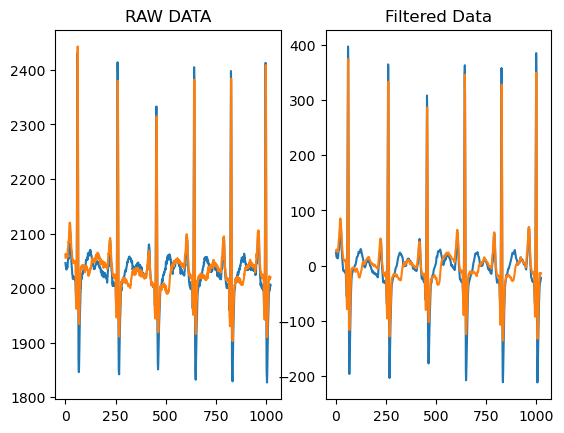

In [5]:
raw_data = {}
load_raw_from = '../../data_set_raw_ECG/raw_data_dict.pkl'
# To generate ^^ Run create_raw_json_and_pkl.py

with open(load_raw_from, 'rb') as f:
    raw_data = pickle.load(f)

filtered_data = copy.deepcopy(raw_data)
filtered_data = data_filter(filtered_data)

fig, axs = plt.subplots(1, 2)
axs[0].plot(raw_data["participant_1"]['ECG']['stimuli'][0][0:1024], label=["CH1", "CH2"])
axs[0].set_title("RAW DATA")

axs[1].plot(filtered_data['participant_1']['ECG']['clip 1']['CH1']['stimuli'][0:1024])
axs[1].plot(filtered_data['participant_1']['ECG']['clip 1']['CH2']['stimuli'][0:1024])
axs[1].set_title("Filtered Data")

# Extract ECG Features

In [6]:
ECG_features = extract_ecg_features(filtered_data)
ECG_features

Processing participant_9 clip 18 CH2           
Done extracting time domain features


,bpm,ibi,sdnn,sdsd,rmssd,pnn20,pnn50,hr_mad,sd1,sd2,s,sd1/sd2,breathingrate,ScoreValence,ScoreArousal,ScoreDominance
0,80.509454,745.254089,37.015695,14.440489,23.468189,0.367925,0.037736,23.437500,16.589278,49.718637,2591.173886,0.333663,0.100000,4,3,2
1,80.705859,743.440448,48.846686,19.889675,29.236669,0.371429,0.076190,33.203125,20.673447,66.233059,4301.674892,0.312132,0.133333,4,3,2
2,76.372766,785.620359,65.265267,21.760162,34.277205,0.470000,0.160000,46.875000,24.219443,88.898887,6764.105105,0.272438,0.133333,3,3,1
3,76.489498,784.421411,37.990842,16.527454,27.792083,0.400000,0.100000,27.343750,19.632083,49.403825,3047.030759,0.397380,0.266667,5,4,4
4,80.550141,744.877653,60.682510,15.128795,23.517967,0.371429,0.038095,39.062500,16.628382,84.576428,4418.239095,0.196608,0.266667,5,4,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1743,72.013029,833.182566,21.107251,10.879065,17.964052,0.255319,0.000000,11.718750,12.697608,26.729556,1066.260979,0.475040,0.300000,2,4,4
1744,72.339089,829.427083,26.195833,10.703118,16.865822,0.200000,0.010526,15.625000,11.925902,35.170987,1317.727633,0.339084,0.300000,2,4,4
1745,76.360925,785.742188,29.560661,8.893522,15.540928,0.181818,0.000000,19.531250,10.988776,40.471877,1397.180651,0.271516,0.300000,2,4,4
1746,67.241071,892.311790,27.285319,14.795161,24.825688,0.425287,0.057471,17.578125,17.548784,34.209326,1885.998807,0.512982,0.266667,3,4,4


# Define Models (WITH NO PCA)

In [7]:
# Define your feature set and labels
cudf_ECG_features = cudf.DataFrame.from_pandas(ECG_features)
X = cudf_ECG_features[['bpm', 'ibi', 'sdnn', 'sdsd', 'rmssd', 'pnn20', 'pnn50', 'hr_mad', 'sd1', 'sd2', 's', 'sd1/sd2', 'breathingrate']]
Y_valence = cudf_ECG_features['ScoreValence']
Y_arousal = cudf_ECG_features['ScoreArousal']
Y_dominance = cudf_ECG_features['ScoreDominance']

# Initialize variables to track the best model and parameters for each label
best_models = {
    'ScoreValence': {'score': float('-inf'), 'model': None, 'params': None},
    'ScoreArousal': {'score': float('-inf'), 'model': None, 'params': None},
    'ScoreDominance': {'score': float('-inf'), 'model': None, 'params': None}
}

# Define a range of hyperparameters for each algorithm
hyperparameters = {
    RandomForestClassifier: {'n_estimators': [100, 200, 300, 400], 'max_depth': [5, 10, 15, 20, 25, 30, 35]},
    SVC: {'C': [1, 10, 100], 'kernel': ['rbf']},
    LinearSVC: {'C': [1, 10, 100]},
    LogisticRegression: {'C': [1, 10, 100]}
    # Add other algorithms and their hyperparameters here
}

model_list = {
    'RandomForestClassifier': {}, 
    'SVC':{}, 
    'LinearSVC':{}, 
    'LogisticRegression':{}
}

results_dict = {
    'ScoreValence': model_list,
    'ScoreArousal': model_list,
    'ScoreDominance': model_list

}

# Full search
for algorithm in hyperparameters:
    print("~~~~~~~~~~~~~~~~~~~algorithm " + str(algorithm) + "~~~~~~~~~~~~~~~~~~~")
    for param_combination in itertools.product(*hyperparameters[algorithm].values()):
        params = dict(zip(hyperparameters[algorithm].keys(), param_combination))

        # Train a model for each label
        for output in ['ScoreValence', 'ScoreArousal', 'ScoreDominance']:
            if output == 'ScoreValence':
                Y = Y_valence
            elif output == 'ScoreArousal':
                Y = Y_arousal
            elif output == 'ScoreDominance':
                Y = Y_dominance

            # Split data
            X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

            # Initialize and train model
            model = algorithm(**params)

            # Convert DataFrame/Series to arrays if necessary
            X_train_array = X_train.values
            Y_train_array = Y_train.values

            # Fit the model
            model.fit(X_train_array, Y_train_array)

            # Evaluate model
            score = model.score(X_test, Y_test)

            # Update best_models if current model is better
            if score > best_models[output]['score']:
                best_models[output]['score'] = score
                best_models[output]['model'] = algorithm.__name__
                best_models[output]['params'] = params

            print(f"{output}, Algorithm {algorithm.__name__}, Params: {params}, Score: {score}")

            results_dict[output][algorithm.__name__][str(params)] = score

# Analyze results to determine the best model for each label
# Print the best models and their hyperparameters for each label
print("\n\n~~~~~~~~~~~~~~~~~~~FINISED TRANING MODELS~~~~~~~~~~~~~~~~~~~\n\n")

for label, info in best_models.items():
    print(f"Best Model for {label}: {info['model']} with Score: {info['score']}")
    print(f"Hyperparameters: {info['params']}\n")

~~~~~~~~~~~~~~~~~~~algorithm <class 'cuml.ensemble.randomforestclassifier.RandomForestClassifier'>~~~~~~~~~~~~~~~~~~~


/opt/conda/lib/python3.10/site-packages/cuml/internals/api_decorators.py:188: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)


ScoreValence, Algorithm RandomForestClassifier, Params: {'n_estimators': 100, 'max_depth': 5}, Score: 0.3896848261356354
ScoreArousal, Algorithm RandomForestClassifier, Params: {'n_estimators': 100, 'max_depth': 5}, Score: 0.41547277569770813
ScoreDominance, Algorithm RandomForestClassifier, Params: {'n_estimators': 100, 'max_depth': 5}, Score: 0.3896848261356354
ScoreValence, Algorithm RandomForestClassifier, Params: {'n_estimators': 100, 'max_depth': 10}, Score: 0.5959885120391846
ScoreArousal, Algorithm RandomForestClassifier, Params: {'n_estimators': 100, 'max_depth': 10}, Score: 0.6676217913627625
ScoreDominance, Algorithm RandomForestClassifier, Params: {'n_estimators': 100, 'max_depth': 10}, Score: 0.5673352479934692
ScoreValence, Algorithm RandomForestClassifier, Params: {'n_estimators': 100, 'max_depth': 15}, Score: 0.7564470171928406
ScoreArousal, Algorithm RandomForestClassifier, Params: {'n_estimators': 100, 'max_depth': 15}, Score: 0.8022922873497009
ScoreDominance, Algori

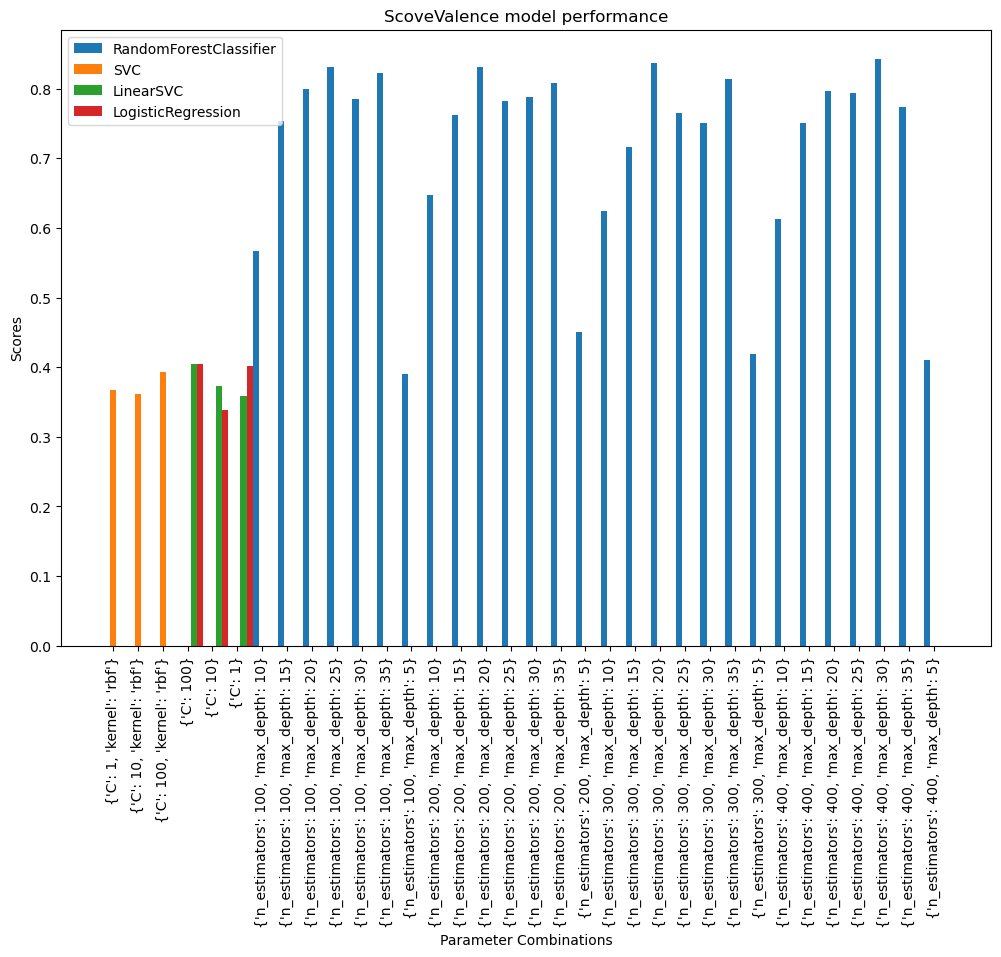

In [8]:
# Plot modele resutls for ScoreValence
plot_model_results(results_dict['ScoreValence'], "ScoveValence model performance")

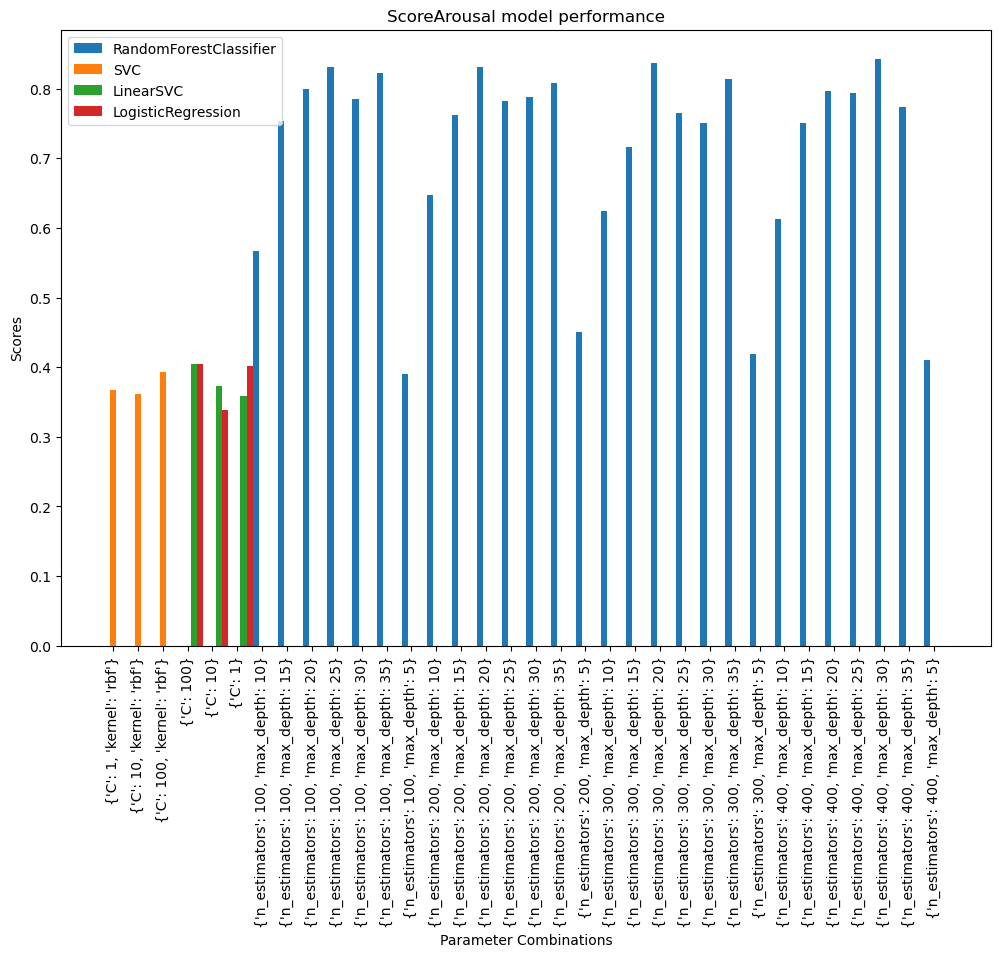

In [9]:
# Plot model results for ScoreArousal
plot_model_results(results_dict['ScoreArousal'], "ScoreArousal model performance")

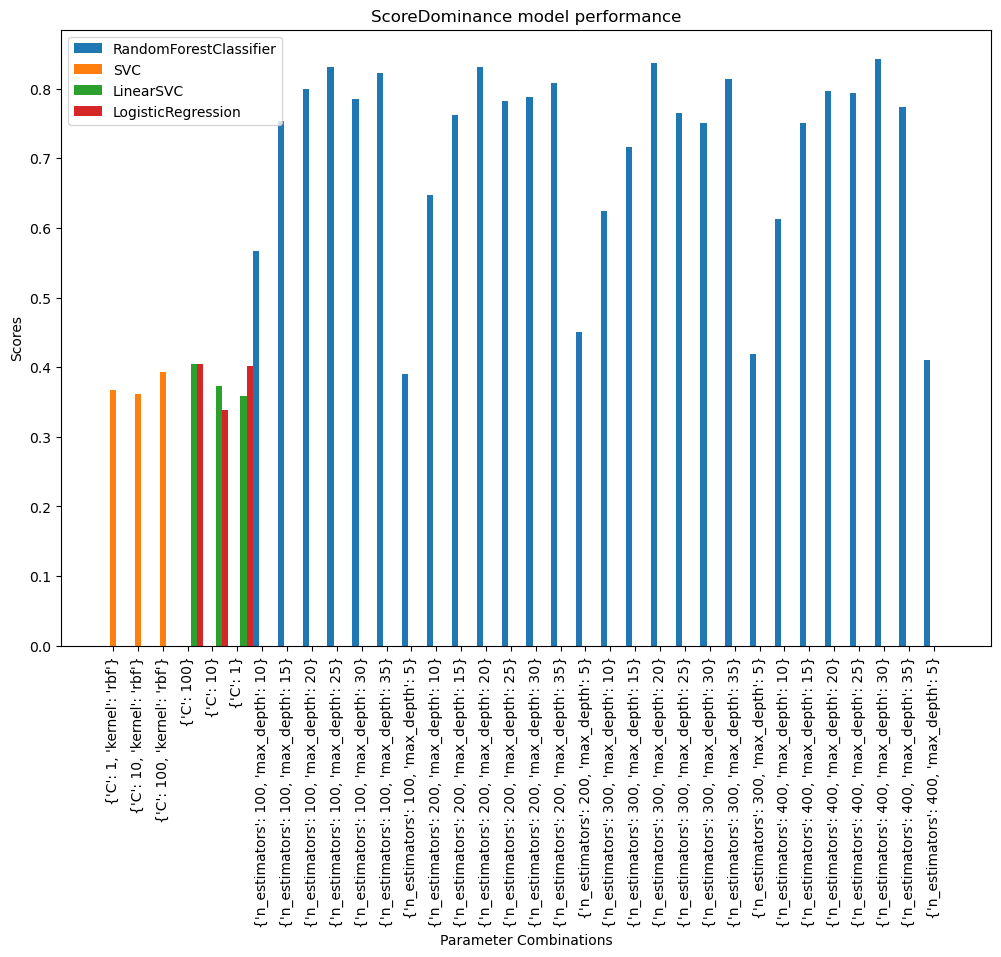

In [10]:
# Plot model results for ScoreDominance
plot_model_results(results_dict['ScoreDominance'], "ScoreDominance model performance")

# Define Models (WITH PCA)

In [11]:
# Initialize variables to track the best model and parameters for each label
best_models_PCA = {
    'ScoreValence': {'score': float('-inf'), 'model': None, 'params': None, 'PCA': None},
    'ScoreArousal': {'score': float('-inf'), 'model': None, 'params': None, 'PCA': None},
    'ScoreDominance': {'score': float('-inf'), 'model': None, 'params': None, 'PCA': None}
}

PCA_list = {
    2:{},
    3:{},
    4:{},
    5:{},
    6:{},
    7:{},
    8:{},
    9:{},
    10:{},
    11:{},
    12:{},
    13:{},
    14:{},
    15:{}
}

model_list_PCA = {
    'RandomForestClassifier': PCA_list, 
    'SVC':PCA_list, 
    'LinearSVC':PCA_list, 
    'LogisticRegression':PCA_list
}

results_dict_PCA = {
    'ScoreValence': model_list_PCA,
    'ScoreArousal': model_list_PCA,
    'ScoreDominance': model_list_PCA

}
# Rest of your script for model selection and evaluation
for PCA_components in [2,3,4,5,6,7,8,9,10,11,12,13]:
    # Apply PCA transformation
    pca = PCA(n_components=PCA_components)
    X_pca = pca.fit_transform(X)

    for algorithm in hyperparameters:
        print("~~~~~~~~~~~~~~~~~~~algorithm " + str(algorithm) + "~~~~~~~~~~~~~~~~~~~")
        for param_combination in itertools.product(*hyperparameters[algorithm].values()):
            params = dict(zip(hyperparameters[algorithm].keys(), param_combination))

            # Train a model for each label
            for output in ['ScoreValence', 'ScoreArousal', 'ScoreDominance']:
                if output == 'ScoreValence':
                    Y = Y_valence
                elif output == 'ScoreArousal':
                    Y = Y_arousal
                elif output == 'ScoreDominance':
                    Y = Y_dominance

                # Split data
                X_train, X_test, Y_train, Y_test = train_test_split(X_pca, Y, test_size=0.2)

                # Initialize and train model
                model = algorithm(**params)

                # Convert DataFrame/Series to arrays if necessary
                X_train_array = X_train.values
                Y_train_array = Y_train.values

                # Fit the model
                model.fit(X_train_array, Y_train_array)

                # Evaluate model
                score = model.score(X_test, Y_test)

                # Update best_models if current model is better
                if score > best_models_PCA[output]['score']:
                    best_models_PCA[output]['score'] = score
                    best_models_PCA[output]['model'] = algorithm.__name__
                    best_models_PCA[output]['params'] = params
                    best_models_PCA[output]['PCA'] = PCA_components

                print(f"{output}, Algorithm {algorithm.__name__}, PCA: {PCA_components}, Params: {params}, Score: {score}")

                results_dict_PCA[output][algorithm.__name__][PCA_components][str(params)] = score

# Analyze results to determine the best model for each label
# Print the best models and their hyperparameters for each label
print("\n\n~~~~~~~~~~~~~~~~~~~FINISED TRANING MODELS~~~~~~~~~~~~~~~~~~~\n\n")

for label, info in best_models_PCA.items():
    print(f"Best Model for {label}: {info['model']} with Score: {info['score']}")
    print(f"Hyperparameters: {info['params']}\n")

~~~~~~~~~~~~~~~~~~~algorithm <class 'cuml.ensemble.randomforestclassifier.RandomForestClassifier'>~~~~~~~~~~~~~~~~~~~


/opt/conda/lib/python3.10/site-packages/cuml/internals/api_decorators.py:188: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)


ScoreValence, Algorithm RandomForestClassifier, PCA: 2, Params: {'n_estimators': 100, 'max_depth': 5}, Score: 0.30085960030555725
ScoreArousal, Algorithm RandomForestClassifier, PCA: 2, Params: {'n_estimators': 100, 'max_depth': 5}, Score: 0.343839555978775
ScoreDominance, Algorithm RandomForestClassifier, PCA: 2, Params: {'n_estimators': 100, 'max_depth': 5}, Score: 0.3553008735179901
ScoreValence, Algorithm RandomForestClassifier, PCA: 2, Params: {'n_estimators': 100, 'max_depth': 10}, Score: 0.2836676239967346
ScoreArousal, Algorithm RandomForestClassifier, PCA: 2, Params: {'n_estimators': 100, 'max_depth': 10}, Score: 0.3381088972091675
ScoreDominance, Algorithm RandomForestClassifier, PCA: 2, Params: {'n_estimators': 100, 'max_depth': 10}, Score: 0.3896848261356354
ScoreValence, Algorithm RandomForestClassifier, PCA: 2, Params: {'n_estimators': 100, 'max_depth': 15}, Score: 0.2865329384803772
ScoreArousal, Algorithm RandomForestClassifier, PCA: 2, Params: {'n_estimators': 100, 'ma

/opt/conda/lib/python3.10/site-packages/cuml/internals/api_decorators.py:188: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)


ScoreValence, Algorithm RandomForestClassifier, PCA: 3, Params: {'n_estimators': 100, 'max_depth': 5}, Score: 0.30085960030555725
ScoreArousal, Algorithm RandomForestClassifier, PCA: 3, Params: {'n_estimators': 100, 'max_depth': 5}, Score: 0.3782235085964203
ScoreDominance, Algorithm RandomForestClassifier, PCA: 3, Params: {'n_estimators': 100, 'max_depth': 5}, Score: 0.406876802444458
ScoreValence, Algorithm RandomForestClassifier, PCA: 3, Params: {'n_estimators': 100, 'max_depth': 10}, Score: 0.42406877875328064
ScoreArousal, Algorithm RandomForestClassifier, PCA: 3, Params: {'n_estimators': 100, 'max_depth': 10}, Score: 0.47277936339378357
ScoreDominance, Algorithm RandomForestClassifier, PCA: 3, Params: {'n_estimators': 100, 'max_depth': 10}, Score: 0.48424068093299866
ScoreValence, Algorithm RandomForestClassifier, PCA: 3, Params: {'n_estimators': 100, 'max_depth': 15}, Score: 0.4355300962924957
ScoreArousal, Algorithm RandomForestClassifier, PCA: 3, Params: {'n_estimators': 100, 

/opt/conda/lib/python3.10/site-packages/cuml/internals/api_decorators.py:188: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)


ScoreValence, Algorithm RandomForestClassifier, PCA: 4, Params: {'n_estimators': 100, 'max_depth': 5}, Score: 0.32091689109802246
ScoreArousal, Algorithm RandomForestClassifier, PCA: 4, Params: {'n_estimators': 100, 'max_depth': 5}, Score: 0.406876802444458
ScoreDominance, Algorithm RandomForestClassifier, PCA: 4, Params: {'n_estimators': 100, 'max_depth': 5}, Score: 0.42406877875328064
ScoreValence, Algorithm RandomForestClassifier, PCA: 4, Params: {'n_estimators': 100, 'max_depth': 10}, Score: 0.5128939747810364
ScoreArousal, Algorithm RandomForestClassifier, PCA: 4, Params: {'n_estimators': 100, 'max_depth': 10}, Score: 0.5816618800163269
ScoreDominance, Algorithm RandomForestClassifier, PCA: 4, Params: {'n_estimators': 100, 'max_depth': 10}, Score: 0.6017192006111145
ScoreValence, Algorithm RandomForestClassifier, PCA: 4, Params: {'n_estimators': 100, 'max_depth': 15}, Score: 0.6275071501731873
ScoreArousal, Algorithm RandomForestClassifier, PCA: 4, Params: {'n_estimators': 100, 'm

/opt/conda/lib/python3.10/site-packages/cuml/internals/api_decorators.py:188: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)


ScoreValence, Algorithm RandomForestClassifier, PCA: 5, Params: {'n_estimators': 100, 'max_depth': 5}, Score: 0.3581661880016327
ScoreArousal, Algorithm RandomForestClassifier, PCA: 5, Params: {'n_estimators': 100, 'max_depth': 5}, Score: 0.467048704624176
ScoreDominance, Algorithm RandomForestClassifier, PCA: 5, Params: {'n_estimators': 100, 'max_depth': 5}, Score: 0.4383954107761383
ScoreValence, Algorithm RandomForestClassifier, PCA: 5, Params: {'n_estimators': 100, 'max_depth': 10}, Score: 0.5300859808921814
ScoreArousal, Algorithm RandomForestClassifier, PCA: 5, Params: {'n_estimators': 100, 'max_depth': 10}, Score: 0.5873925685882568
ScoreDominance, Algorithm RandomForestClassifier, PCA: 5, Params: {'n_estimators': 100, 'max_depth': 10}, Score: 0.610315203666687
ScoreValence, Algorithm RandomForestClassifier, PCA: 5, Params: {'n_estimators': 100, 'max_depth': 15}, Score: 0.6934097409248352
ScoreArousal, Algorithm RandomForestClassifier, PCA: 5, Params: {'n_estimators': 100, 'max_

/opt/conda/lib/python3.10/site-packages/cuml/internals/api_decorators.py:188: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)


ScoreValence, Algorithm RandomForestClassifier, PCA: 6, Params: {'n_estimators': 100, 'max_depth': 5}, Score: 0.33237820863723755
ScoreArousal, Algorithm RandomForestClassifier, PCA: 6, Params: {'n_estimators': 100, 'max_depth': 5}, Score: 0.49283668398857117
ScoreDominance, Algorithm RandomForestClassifier, PCA: 6, Params: {'n_estimators': 100, 'max_depth': 5}, Score: 0.3868194818496704
ScoreValence, Algorithm RandomForestClassifier, PCA: 6, Params: {'n_estimators': 100, 'max_depth': 10}, Score: 0.5444126129150391
ScoreArousal, Algorithm RandomForestClassifier, PCA: 6, Params: {'n_estimators': 100, 'max_depth': 10}, Score: 0.5902578830718994
ScoreDominance, Algorithm RandomForestClassifier, PCA: 6, Params: {'n_estimators': 100, 'max_depth': 10}, Score: 0.5816618800163269
ScoreValence, Algorithm RandomForestClassifier, PCA: 6, Params: {'n_estimators': 100, 'max_depth': 15}, Score: 0.6905444264411926
ScoreArousal, Algorithm RandomForestClassifier, PCA: 6, Params: {'n_estimators': 100, '

/opt/conda/lib/python3.10/site-packages/cuml/internals/api_decorators.py:188: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)


ScoreValence, Algorithm RandomForestClassifier, PCA: 7, Params: {'n_estimators': 100, 'max_depth': 5}, Score: 0.3696275055408478
ScoreArousal, Algorithm RandomForestClassifier, PCA: 7, Params: {'n_estimators': 100, 'max_depth': 5}, Score: 0.44412606954574585
ScoreDominance, Algorithm RandomForestClassifier, PCA: 7, Params: {'n_estimators': 100, 'max_depth': 5}, Score: 0.38395416736602783
ScoreValence, Algorithm RandomForestClassifier, PCA: 7, Params: {'n_estimators': 100, 'max_depth': 10}, Score: 0.5530086159706116
ScoreArousal, Algorithm RandomForestClassifier, PCA: 7, Params: {'n_estimators': 100, 'max_depth': 10}, Score: 0.5816618800163269
ScoreDominance, Algorithm RandomForestClassifier, PCA: 7, Params: {'n_estimators': 100, 'max_depth': 10}, Score: 0.6074498295783997
ScoreValence, Algorithm RandomForestClassifier, PCA: 7, Params: {'n_estimators': 100, 'max_depth': 15}, Score: 0.670487105846405
ScoreArousal, Algorithm RandomForestClassifier, PCA: 7, Params: {'n_estimators': 100, 'm

/opt/conda/lib/python3.10/site-packages/cuml/internals/api_decorators.py:188: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)


ScoreValence, Algorithm RandomForestClassifier, PCA: 8, Params: {'n_estimators': 100, 'max_depth': 5}, Score: 0.34097421169281006
ScoreArousal, Algorithm RandomForestClassifier, PCA: 8, Params: {'n_estimators': 100, 'max_depth': 5}, Score: 0.46418339014053345
ScoreDominance, Algorithm RandomForestClassifier, PCA: 8, Params: {'n_estimators': 100, 'max_depth': 5}, Score: 0.41547277569770813
ScoreValence, Algorithm RandomForestClassifier, PCA: 8, Params: {'n_estimators': 100, 'max_depth': 10}, Score: 0.5616045594215393
ScoreArousal, Algorithm RandomForestClassifier, PCA: 8, Params: {'n_estimators': 100, 'max_depth': 10}, Score: 0.6217765212059021
ScoreDominance, Algorithm RandomForestClassifier, PCA: 8, Params: {'n_estimators': 100, 'max_depth': 10}, Score: 0.5873925685882568
ScoreValence, Algorithm RandomForestClassifier, PCA: 8, Params: {'n_estimators': 100, 'max_depth': 15}, Score: 0.6819484233856201
ScoreArousal, Algorithm RandomForestClassifier, PCA: 8, Params: {'n_estimators': 100, 

/opt/conda/lib/python3.10/site-packages/cuml/internals/api_decorators.py:188: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)


ScoreValence, Algorithm RandomForestClassifier, PCA: 9, Params: {'n_estimators': 100, 'max_depth': 5}, Score: 0.39255014061927795
ScoreArousal, Algorithm RandomForestClassifier, PCA: 9, Params: {'n_estimators': 100, 'max_depth': 5}, Score: 0.4383954107761383
ScoreDominance, Algorithm RandomForestClassifier, PCA: 9, Params: {'n_estimators': 100, 'max_depth': 5}, Score: 0.3982807993888855
ScoreValence, Algorithm RandomForestClassifier, PCA: 9, Params: {'n_estimators': 100, 'max_depth': 10}, Score: 0.5673352479934692
ScoreArousal, Algorithm RandomForestClassifier, PCA: 9, Params: {'n_estimators': 100, 'max_depth': 10}, Score: 0.6275071501731873
ScoreDominance, Algorithm RandomForestClassifier, PCA: 9, Params: {'n_estimators': 100, 'max_depth': 10}, Score: 0.5644699335098267
ScoreValence, Algorithm RandomForestClassifier, PCA: 9, Params: {'n_estimators': 100, 'max_depth': 15}, Score: 0.7134670615196228
ScoreArousal, Algorithm RandomForestClassifier, PCA: 9, Params: {'n_estimators': 100, 'm

/opt/conda/lib/python3.10/site-packages/cuml/internals/api_decorators.py:188: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)


ScoreValence, Algorithm RandomForestClassifier, PCA: 10, Params: {'n_estimators': 100, 'max_depth': 5}, Score: 0.3782235085964203
ScoreArousal, Algorithm RandomForestClassifier, PCA: 10, Params: {'n_estimators': 100, 'max_depth': 5}, Score: 0.45272207260131836
ScoreDominance, Algorithm RandomForestClassifier, PCA: 10, Params: {'n_estimators': 100, 'max_depth': 5}, Score: 0.3954154849052429
ScoreValence, Algorithm RandomForestClassifier, PCA: 10, Params: {'n_estimators': 100, 'max_depth': 10}, Score: 0.6074498295783997
ScoreArousal, Algorithm RandomForestClassifier, PCA: 10, Params: {'n_estimators': 100, 'max_depth': 10}, Score: 0.65329509973526
ScoreDominance, Algorithm RandomForestClassifier, PCA: 10, Params: {'n_estimators': 100, 'max_depth': 10}, Score: 0.6131805181503296
ScoreValence, Algorithm RandomForestClassifier, PCA: 10, Params: {'n_estimators': 100, 'max_depth': 15}, Score: 0.65329509973526
ScoreArousal, Algorithm RandomForestClassifier, PCA: 10, Params: {'n_estimators': 100

/opt/conda/lib/python3.10/site-packages/cuml/internals/api_decorators.py:188: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)


ScoreValence, Algorithm RandomForestClassifier, PCA: 11, Params: {'n_estimators': 100, 'max_depth': 5}, Score: 0.34097421169281006
ScoreArousal, Algorithm RandomForestClassifier, PCA: 11, Params: {'n_estimators': 100, 'max_depth': 5}, Score: 0.4383954107761383
ScoreDominance, Algorithm RandomForestClassifier, PCA: 11, Params: {'n_estimators': 100, 'max_depth': 5}, Score: 0.4297994375228882
ScoreValence, Algorithm RandomForestClassifier, PCA: 11, Params: {'n_estimators': 100, 'max_depth': 10}, Score: 0.5730658769607544
ScoreArousal, Algorithm RandomForestClassifier, PCA: 11, Params: {'n_estimators': 100, 'max_depth': 10}, Score: 0.6361031532287598
ScoreDominance, Algorithm RandomForestClassifier, PCA: 11, Params: {'n_estimators': 100, 'max_depth': 10}, Score: 0.6160458326339722
ScoreValence, Algorithm RandomForestClassifier, PCA: 11, Params: {'n_estimators': 100, 'max_depth': 15}, Score: 0.6475644707679749
ScoreArousal, Algorithm RandomForestClassifier, PCA: 11, Params: {'n_estimators':

/opt/conda/lib/python3.10/site-packages/cuml/internals/api_decorators.py:188: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)


ScoreValence, Algorithm RandomForestClassifier, PCA: 12, Params: {'n_estimators': 100, 'max_depth': 5}, Score: 0.39255014061927795
ScoreArousal, Algorithm RandomForestClassifier, PCA: 12, Params: {'n_estimators': 100, 'max_depth': 5}, Score: 0.4383954107761383
ScoreDominance, Algorithm RandomForestClassifier, PCA: 12, Params: {'n_estimators': 100, 'max_depth': 5}, Score: 0.3954154849052429
ScoreValence, Algorithm RandomForestClassifier, PCA: 12, Params: {'n_estimators': 100, 'max_depth': 10}, Score: 0.5587392449378967
ScoreArousal, Algorithm RandomForestClassifier, PCA: 12, Params: {'n_estimators': 100, 'max_depth': 10}, Score: 0.6160458326339722
ScoreDominance, Algorithm RandomForestClassifier, PCA: 12, Params: {'n_estimators': 100, 'max_depth': 10}, Score: 0.6131805181503296
ScoreValence, Algorithm RandomForestClassifier, PCA: 12, Params: {'n_estimators': 100, 'max_depth': 15}, Score: 0.7106017470359802
ScoreArousal, Algorithm RandomForestClassifier, PCA: 12, Params: {'n_estimators':

/opt/conda/lib/python3.10/site-packages/cuml/internals/api_decorators.py:188: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)


ScoreValence, Algorithm RandomForestClassifier, PCA: 13, Params: {'n_estimators': 100, 'max_depth': 5}, Score: 0.4212034344673157
ScoreArousal, Algorithm RandomForestClassifier, PCA: 13, Params: {'n_estimators': 100, 'max_depth': 5}, Score: 0.4584527313709259
ScoreDominance, Algorithm RandomForestClassifier, PCA: 13, Params: {'n_estimators': 100, 'max_depth': 5}, Score: 0.45558738708496094
ScoreValence, Algorithm RandomForestClassifier, PCA: 13, Params: {'n_estimators': 100, 'max_depth': 10}, Score: 0.5873925685882568
ScoreArousal, Algorithm RandomForestClassifier, PCA: 13, Params: {'n_estimators': 100, 'max_depth': 10}, Score: 0.5988538861274719
ScoreDominance, Algorithm RandomForestClassifier, PCA: 13, Params: {'n_estimators': 100, 'max_depth': 10}, Score: 0.6074498295783997
ScoreValence, Algorithm RandomForestClassifier, PCA: 13, Params: {'n_estimators': 100, 'max_depth': 15}, Score: 0.7535816431045532
ScoreArousal, Algorithm RandomForestClassifier, PCA: 13, Params: {'n_estimators':

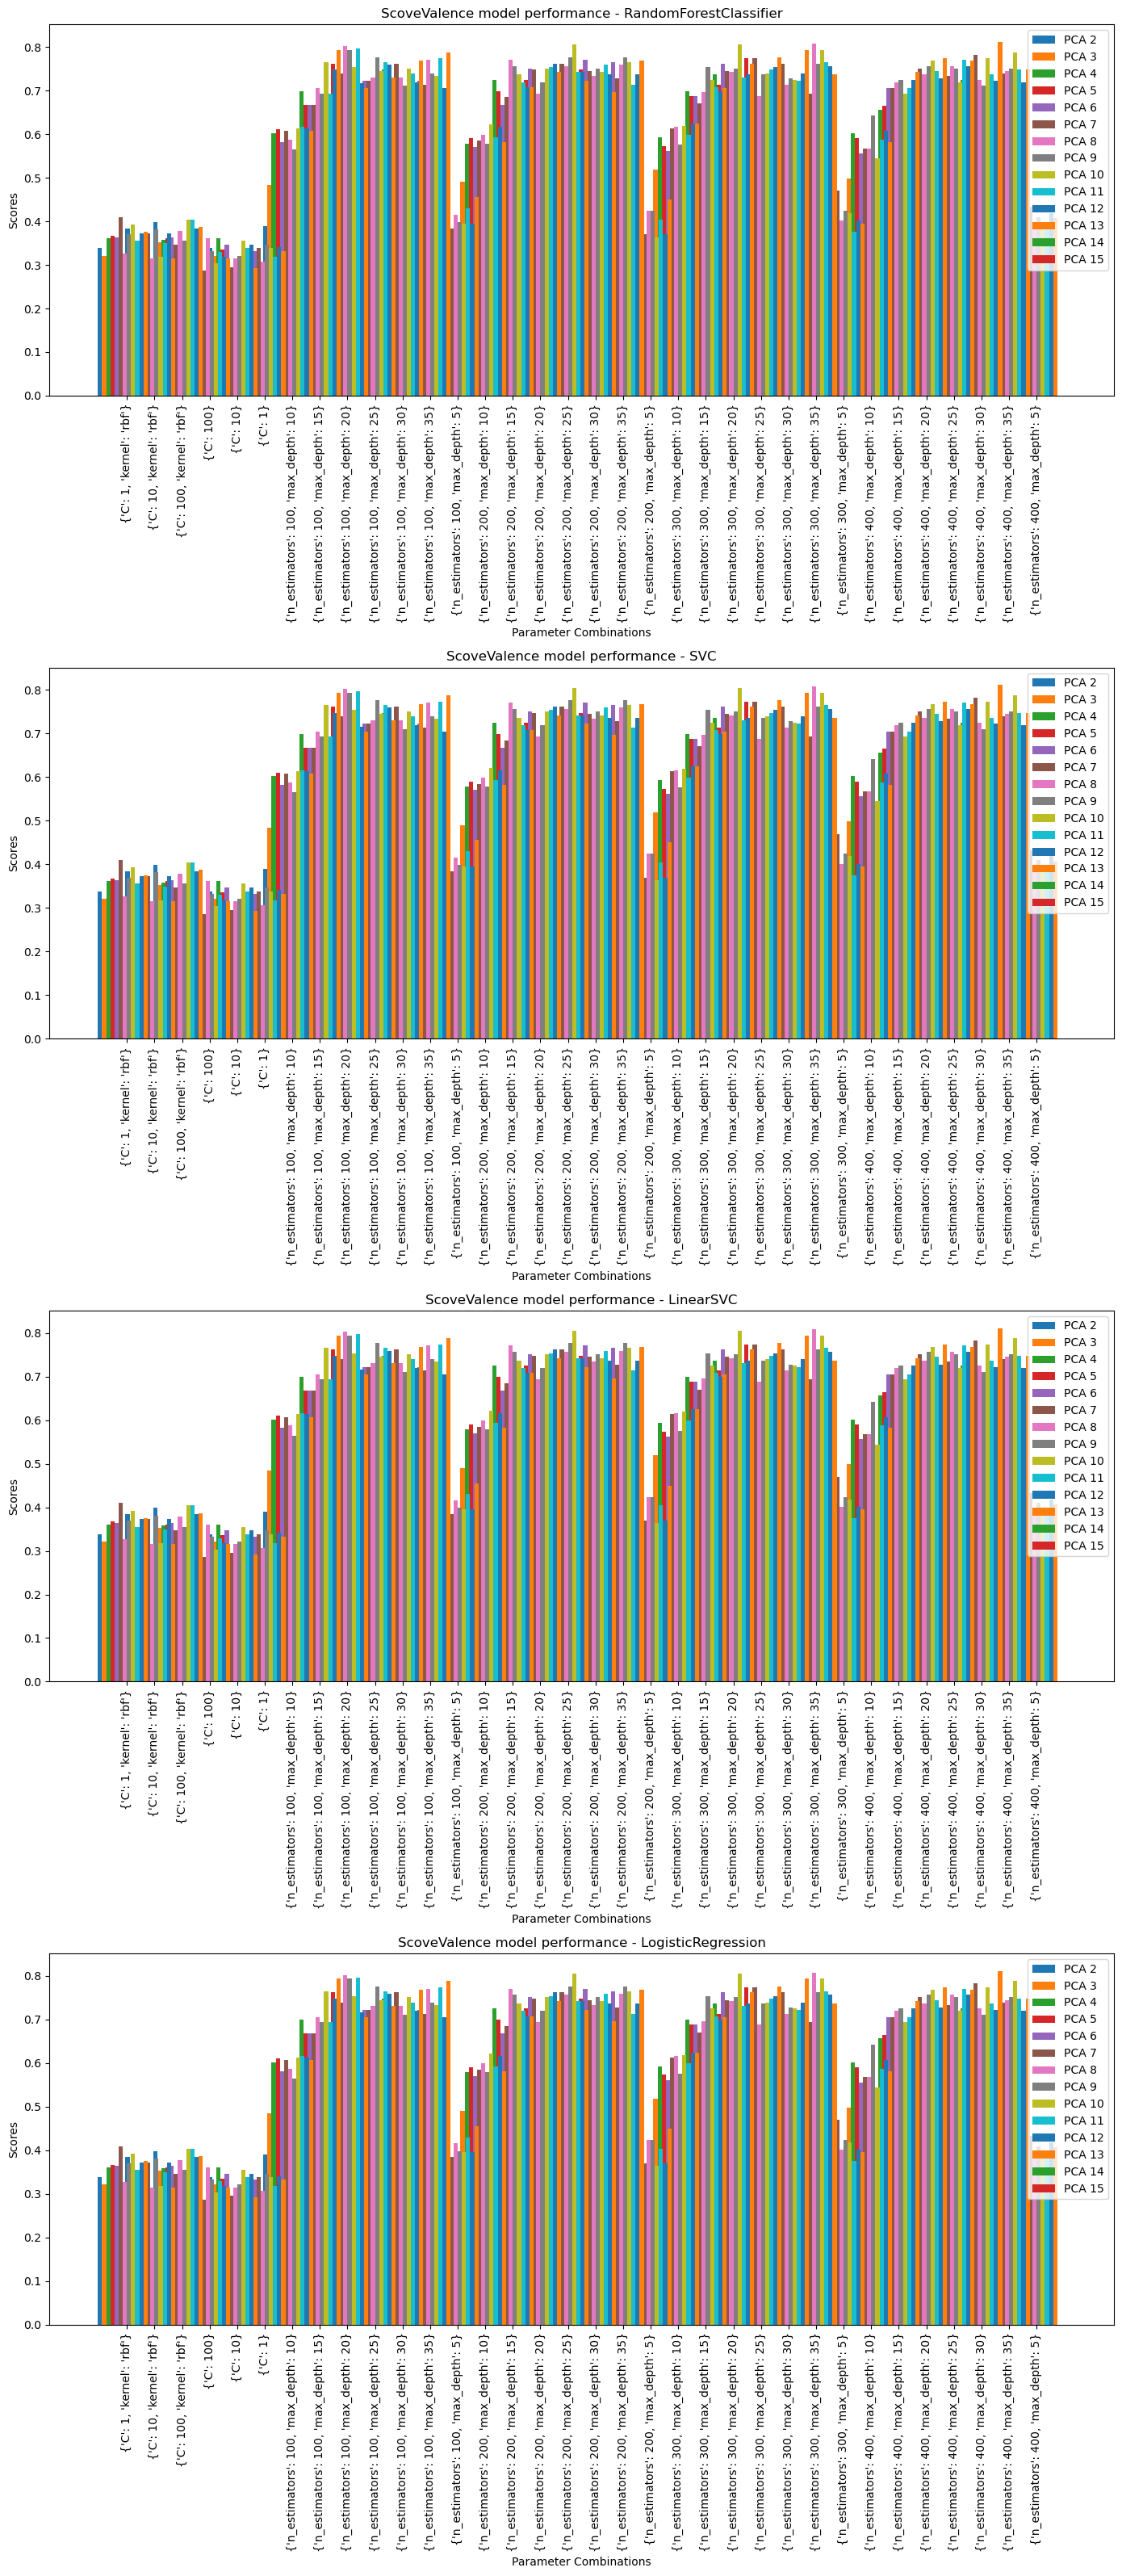

In [12]:
# Plot modele resutls for ScoreValence
plot_model_results_PCA(results_dict_PCA['ScoreValence'], "ScoveValence model performance")

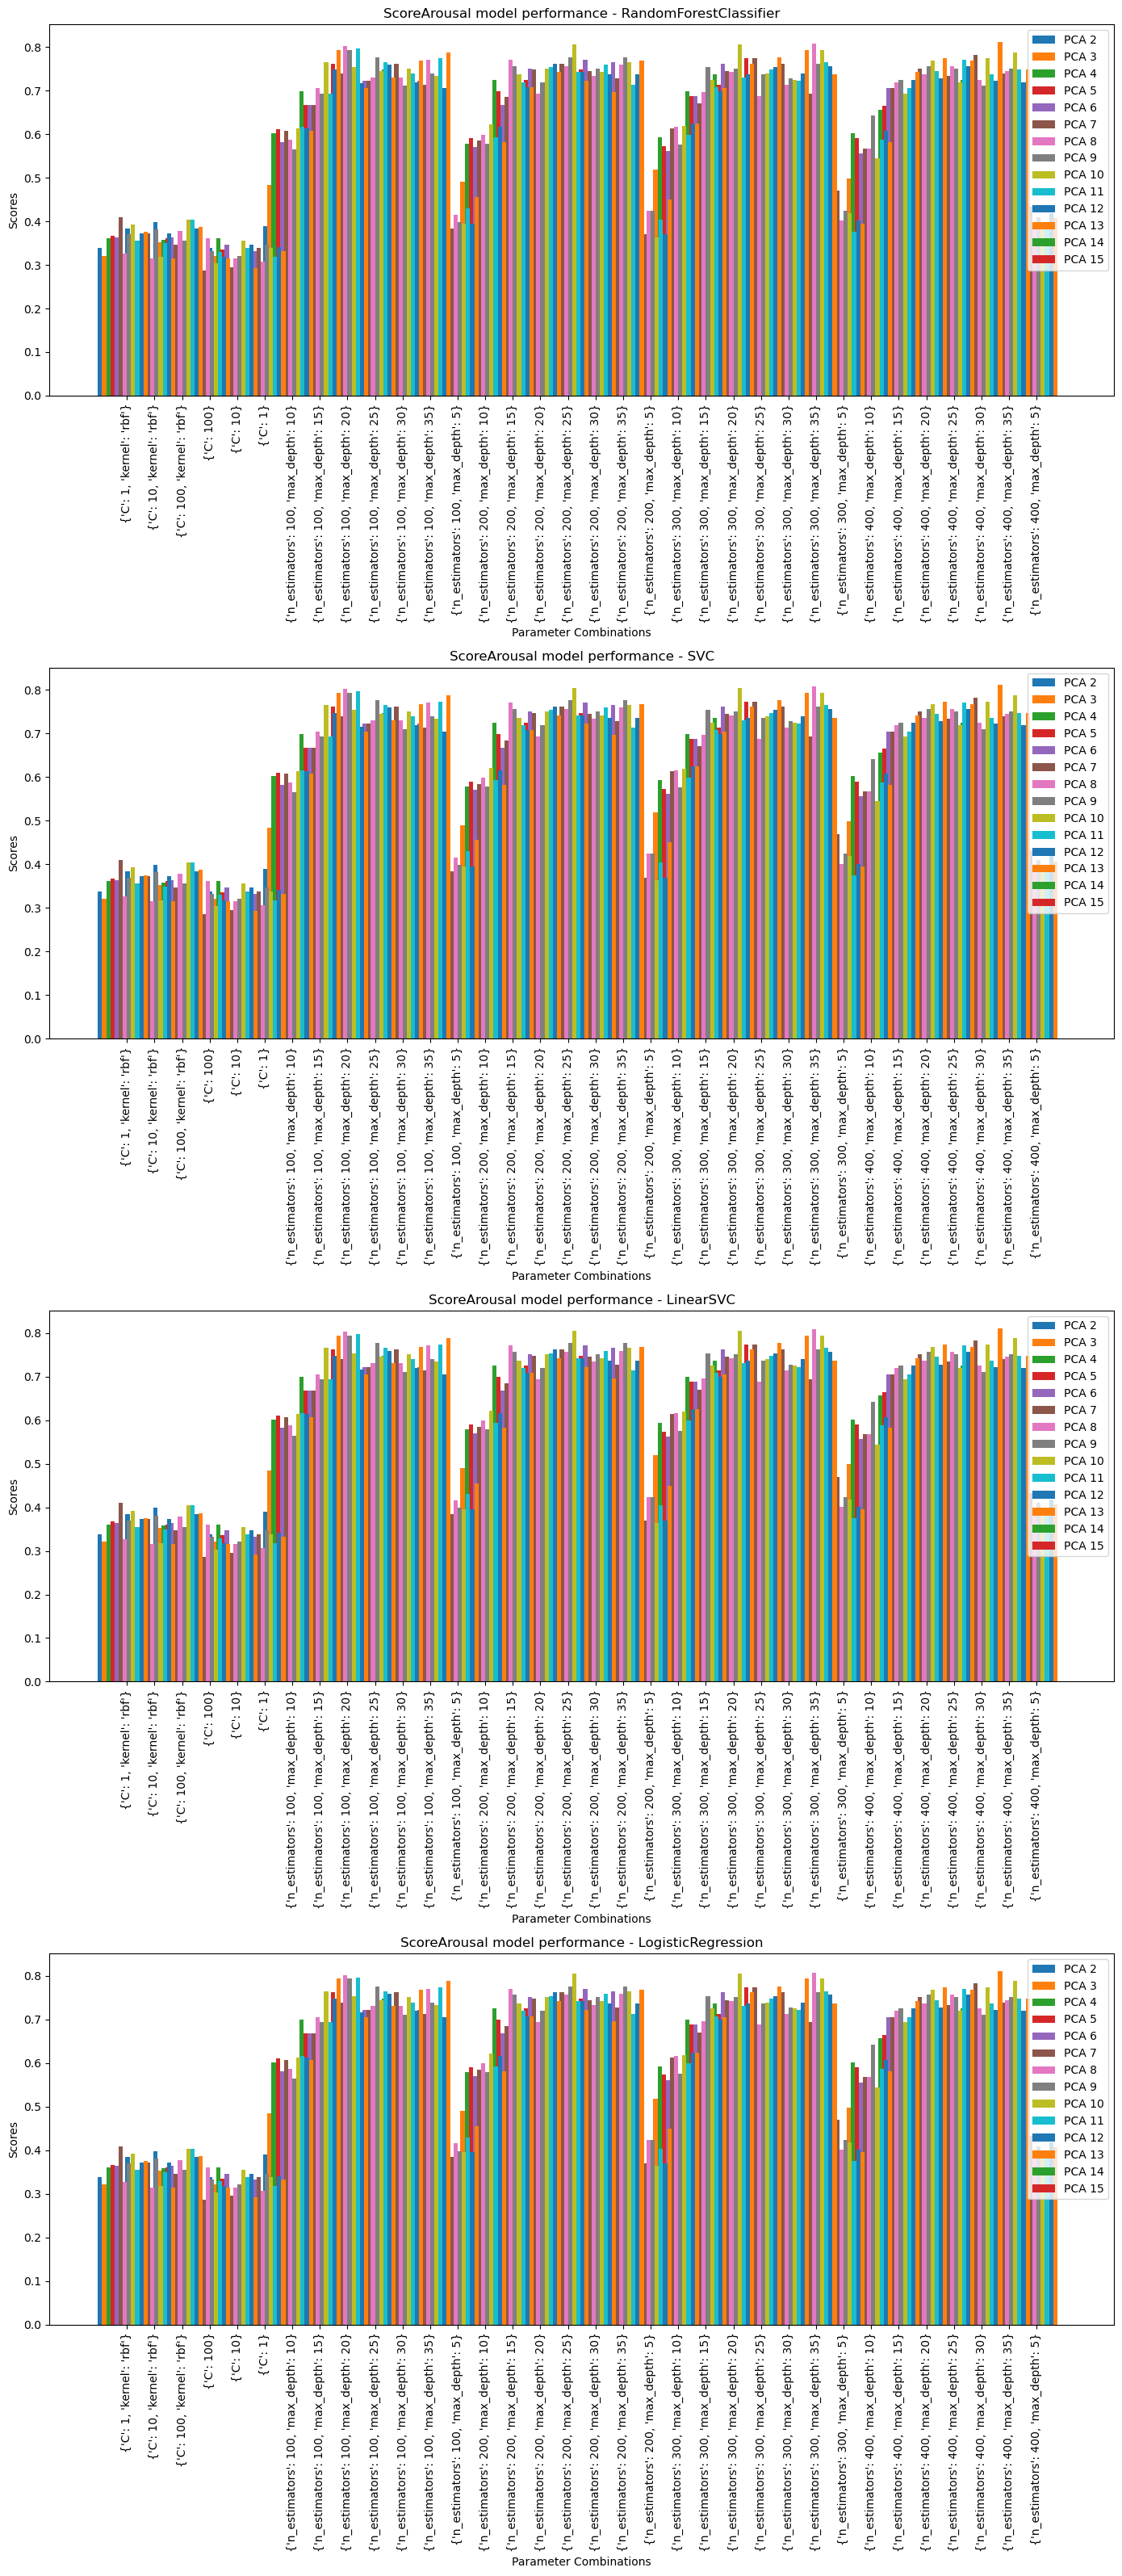

In [13]:
# Plot model results for ScoreArousal
plot_model_results_PCA(results_dict_PCA['ScoreArousal'], "ScoreArousal model performance")

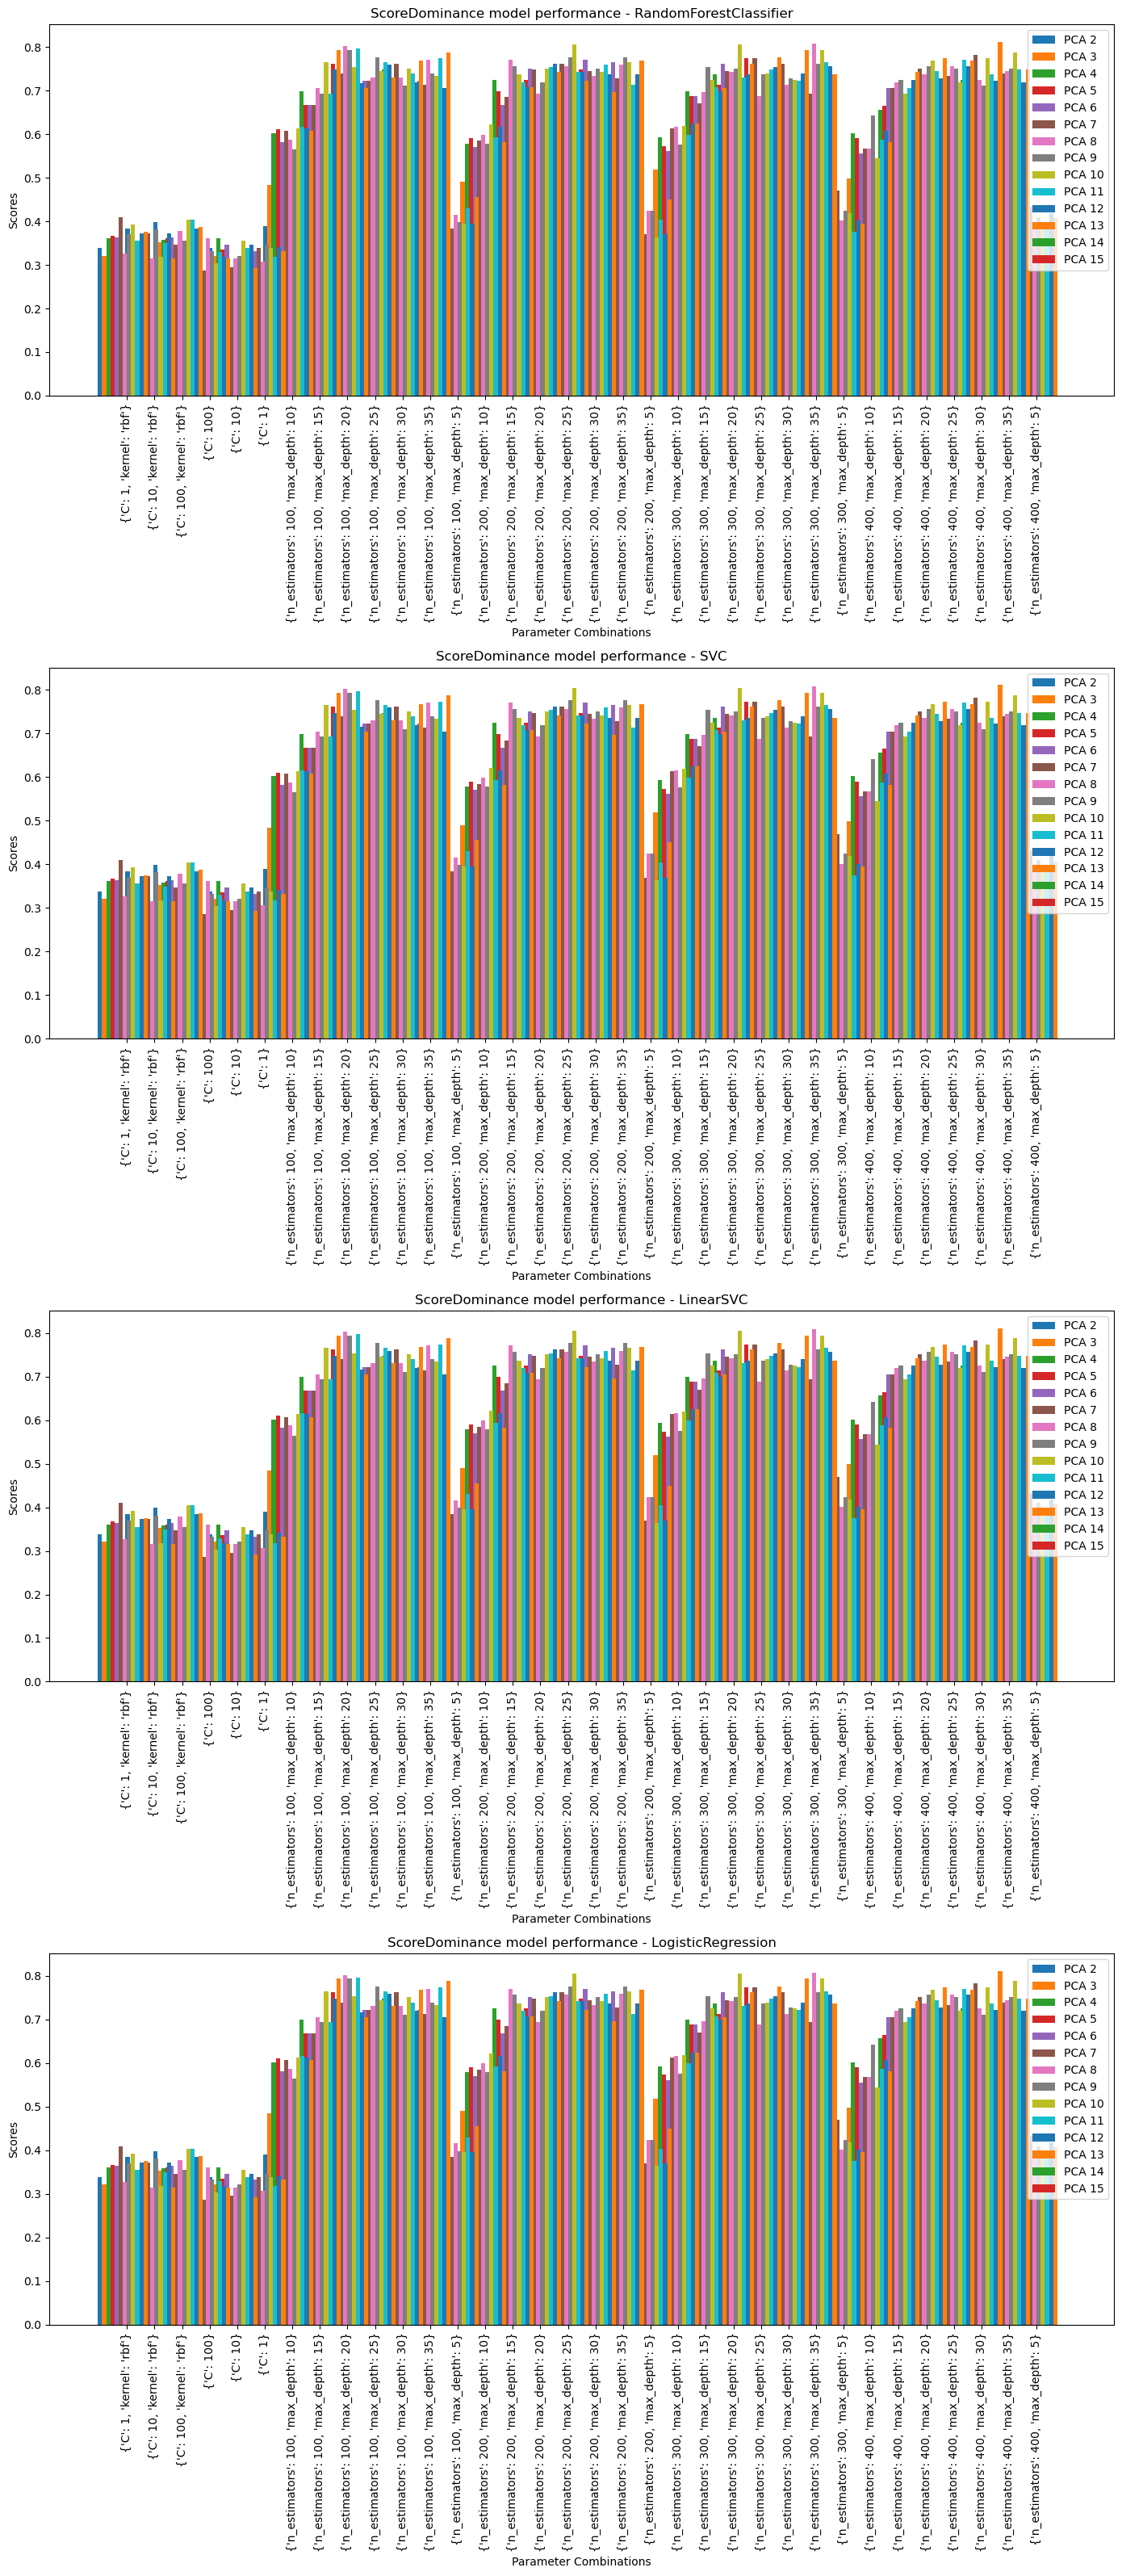

In [14]:
# Plot model results for ScoreDominance
plot_model_results_PCA(results_dict_PCA['ScoreDominance'], "ScoreDominance model performance")